In [76]:
import numpy
import os
import itertools

# Original dimensions: 70, 740, 856

# training data
image_path = 'numpy_data/Ultrasound Volumes/'
segmentation_path = 'numpy_data/Patient Segmentations/'
image_file_list = [image_path + f for f in os.listdir(image_path) if f.endswith('.npy')]
segmentation_file_list = [segmentation_path + f for f in os.listdir(segmentation_path) if f.endswith('.npy')]

# testing data
t_image_path = 'numpy_data/Ultrasound Volumes/Testing Data/'
t_segmentation_path = 'numpy_data/Patient Segmentations/Testing Data/'
t_image_file_list = [t_image_path + f for f in os.listdir(t_image_path) if f.endswith('.npy')]
t_segmentation_file_list = [t_segmentation_path + f for f in os.listdir(t_segmentation_path) if f.endswith('.npy')]


# determine uniform dimensions
def add_elements(dict, key, value1, value2):
    if key not in dict:
        dict[key] = []
    dict[key].append(value1)
    dict[key].append(value2)

dimensions = {}
for file in itertools.chain(segmentation_file_list, t_segmentation_file_list):
    segmentation_array = numpy.load(file)
    x, y, z = numpy.where(segmentation_array != 0)
    add_elements(dimensions, 'x', min(x), max(x))
    add_elements(dimensions, 'y', min(y), max(y))
    add_elements(dimensions, 'z', min(z), max(z))

# segmentation_array = segmentation_array[min(x):max(x)+1, min(y):max(y)+1, min(z):max(z)+1]
x_list = dimensions.get('x')
y_list = dimensions.get('y')
z_list = dimensions.get('z')

min_x = min(x_list)
max_x = max(x_list)
min_y = min(y_list)
max_y = max(y_list)
min_z = min(z_list)
max_z = max(z_list)

In [77]:
# crop and stack training arrays

segmentation_arrays = []
for file in segmentation_file_list:
    segmentation_array = numpy.load(file)
    # crop
    segmentation_array = segmentation_array[min_x:max_x+1, min_y:max_y+1, min_z:max_z+1]
    # print(segmentation_array.shape)
    # resize
    segmentation_array = numpy.resize(segmentation_array, (128, 128, 128))
    segmentation_array = numpy.expand_dims(segmentation_array, 3)
    segmentation_arrays.append(segmentation_array)
    

image_arrays = []
for file in image_file_list:
    image_array = numpy.load(file)
    # crop 
    image_array = image_array[min_x:max_x+1, min_y:max_y+1, min_z:max_z+1]
    # print(image_array.shape)
    # resize
    image_array = numpy.resize(image_array, (128, 128, 128))
    image_array = numpy.expand_dims(image_array, 3)
    image_arrays.append(image_array)


stacked_image_array = numpy.stack(image_arrays)
stacked_segmentation_array = numpy.stack(segmentation_arrays)

print(stacked_image_array.shape)
print(stacked_segmentation_array.shape)

# export as numpy files
image_file = 'numpy_data/Stacked Arrays/stacked_image_array'
segmentation_file = 'numpy_data/Stacked Arrays/stacked_segmentation_array'

numpy.save(image_file, stacked_image_array)
numpy.save(segmentation_file, stacked_segmentation_array)

(24, 128, 128, 128, 1)
(24, 128, 128, 128, 1)


In [78]:
# crop and stack testing arrays

segmentation_arrays = []
for file in t_segmentation_file_list:
    segmentation_array = numpy.load(file)
    # crop
    segmentation_array = segmentation_array[min_x:max_x+1, min_y:max_y+1, min_z:max_z+1]
    # print(segmentation_array.shape)
    # resize
    segmentation_array = numpy.resize(segmentation_array, (128, 128, 128))
    segmentation_array = numpy.expand_dims(segmentation_array, 3)
    segmentation_arrays.append(segmentation_array)
    

image_arrays = []
for file in t_image_file_list:
    image_array = numpy.load(file)
    # crop 
    image_array = image_array[min_x:max_x+1, min_y:max_y+1, min_z:max_z+1]
    # print(image_array.shape)
    # resize
    image_array = numpy.resize(image_array, (128, 128, 128))
    image_array = numpy.expand_dims(image_array, 3)
    image_arrays.append(image_array)


stacked_image_array = numpy.stack(image_arrays)
stacked_segmentation_array = numpy.stack(segmentation_arrays)

print(stacked_image_array.shape)
print(stacked_segmentation_array.shape)

# export as numpy files
image_file = 'numpy_data/Stacked Arrays/stacked_image_array'
segmentation_file = 'numpy_data/Stacked Arrays/stacked_segmentation_array'

numpy.save(image_file, stacked_image_array)
numpy.save(segmentation_file, stacked_segmentation_array)

(6, 128, 128, 128, 1)
(6, 128, 128, 128, 1)


In [79]:
%matplotlib notebook

In [80]:
import matplotlib.pyplot as plt

test_array = numpy.load('numpy_data/Ultrasound Volumes/ultrasound03.npy')
test_array2 = numpy.load('numpy_data/Patient Segmentations/brachy_patient03.npy')
# plt.imshow(test_array[11])

In [81]:
def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

(77, 496, 546)


<IPython.core.display.Javascript object>


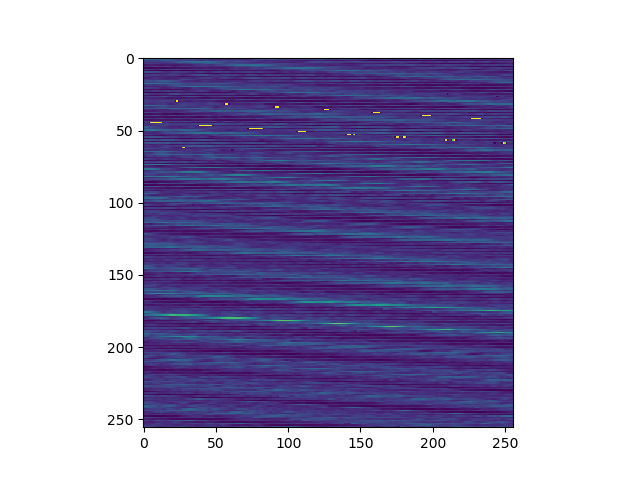

In [82]:
cropped_arr = test_array[min_x:max_x+1, min_y:max_y+1, min_z:max_z+1]
print(cropped_arr.shape)
resized_arr = numpy.resize(cropped_arr, (77, 256, 256))
multi_slice_viewer(resized_arr)

(77, 496, 546)


<IPython.core.display.Javascript object>


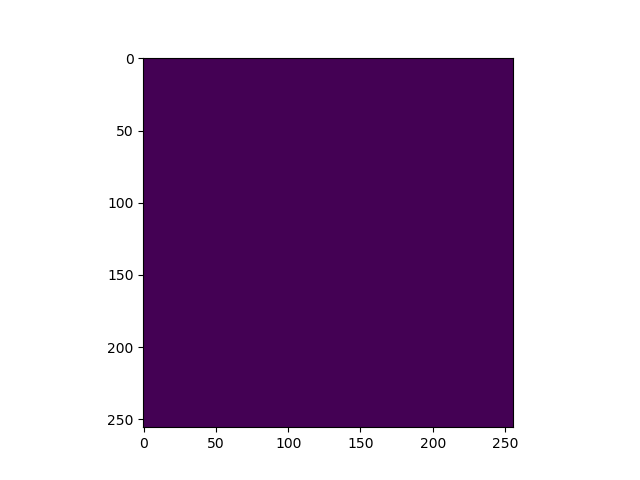

In [83]:
cropped_arr = test_array2[min_x:max_x+1, min_y:max_y+1, min_z:max_z+1]
print(cropped_arr.shape)
resized_arr = numpy.resize(cropped_arr, (77, 256, 256))
multi_slice_viewer(resized_arr)